In [ ]:
SAMPLE_RATE = 22050 
DURATION = 1
OFFSET=10

SAMPLE_LENGTH = SAMPLE_RATE * DURATION


data_amount = 2000 # Сколько файлов (записей) взять для обучения и тестирования 
train_amount_percent = 0.8 # процент обучающей выборки из всех данных


first_layer = 12000
latent_dim = 8000
learning_rate = 0.0000001
epochs = 50
batch_size = 64

## Загрузчик данных

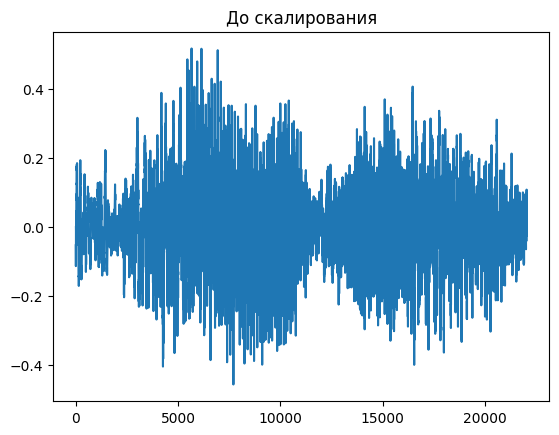

tensor([-0.0536, -0.0720, -0.0639,  ...,  0.0600,  0.0038, -0.0391])


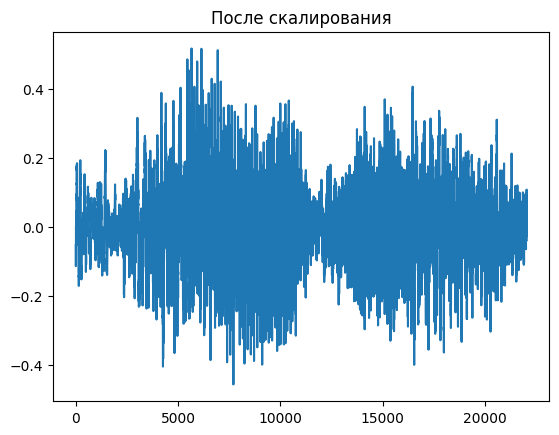

In [40]:
from torch.utils.data import Dataset
from sklearn import preprocessing
import torch
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
import numpy as np
import joblib
import os.path
from scipy.fft import fft, fftfreq, ifft


def getPathes():
    path = "resources\\fma_small"
    pathes = []

    for subdir in os.listdir(path):
        if subdir == 'README.txt' or subdir == 'checksums': continue
        f_path = path+"\\"+subdir
        for file in os.listdir(f_path):
            if file.endswith(".mp3"):
                pathes.append(os.path.join(f_path, file))

    return pathes

class CustomAudioDataset(Dataset):
    def __init__(self, pathes):
        self.scaler_filename = "scaler.save"
        self.pathes = pathes
        self.min_len = SAMPLE_LENGTH
        self.is_use_fft = False
        self.scaler = preprocessing.MinMaxScaler((0,1))
        self.fit_scaler()

    def __len__(self):
        return self.pathes.__len__()

    def __getitem__(self, idx):
        audio = self.loader(idx)
        #audio = self.scaler.transform([audio])[0]
        #audio = torch.from_numpy(audio).type(torch.float)
        return audio
    
    


    def loader(self,ind:int): # Загрузка mp3 файла в виде list
        try:
            y, sr = librosa.load(self.pathes[ind], duration=DURATION, sr=SAMPLE_RATE, offset=OFFSET) # Загружает mp3 как массив           
            y = torch.from_numpy(y[:SAMPLE_LENGTH]).type(torch.float)
            return y
        except:
            print("error" + self.pathes[ind].__str__())


    def fit_scaler(self): #создаю скалер
       
        dump_exist = os.path.isfile(self.scaler_filename) 
 
        if dump_exist:
            self.scaler = joblib.load(self.scaler_filename)# чтобы не обучать каждый раз заново, загружу из дампа 
            return

        for p in range(0, self.pathes.__len__()):
            y = self.loader(p)
            self.scaler.partial_fit(np.array(y).reshape(1, -1))

        joblib.dump(self.scaler, self.scaler_filename) 





    
pathes = getPathes()
random.shuffle(pathes)
part_pathes = pathes[:data_amount]
train_end_index = round(part_pathes.__len__()*train_amount_percent)
train_ds = CustomAudioDataset(part_pathes[:train_end_index]) # Обучающая выборка
test_ds = CustomAudioDataset(part_pathes[train_end_index+1:]) # Тестовая выборка


y, sr = librosa.load(pathes[1], duration=DURATION, sr=SAMPLE_RATE, offset=OFFSET)
plt.plot(y)
plt.title("До скалирования")
plt.show()

item = train_ds.__getitem__(1)
print(item)
plt.plot(item)
plt.title("После скалирования")
plt.show()


# Автоэнкодер

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cpu")



train_dataset = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_dataset = DataLoader(test_ds,batch_size=batch_size,shuffle=True)

class VAE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1=nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek


loss_function = nn.MSELoss()

In [42]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение

In [43]:
import gc
import time 

# Функция обучения
def train(epoch):
    model.train()
    train_loss = 0
    epoch_start_time = time.time()  

    for batch_idx, data in enumerate(train_dataset):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 4 == 0:
            print(f"Эпоха {epoch} [{batch_idx * data.__len__()}/{train_dataset.dataset.__len__()} "
                  f"({100. * batch_idx / train_dataset.__len__():.0f}%)]\tПотеря: {loss.item() / data.__len__():.4f}")

    epoch_end_time = time.time()  
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"====> Эпоха {epoch} Средняя потеря: {train_loss / train_dataset.dataset.__len__():.4f} "
          f"Время: {epoch_duration:.2f} секунд")

# Функция тестирования
def test():
    model.eval()
    test_loss = 0
    test_start_time = time.time()  
    with torch.no_grad():
        for data in train_dataset:
            data = data.to(device)
            recon = model(data)
            test_loss += loss_function(recon, data).item()

    test_end_time = time.time()  
    test_duration = test_end_time - test_start_time
    test_loss /= train_dataset.dataset.__len__()
    print(f"====> Тестовая потеря: {test_loss:.4f} Время: {test_duration:.2f} секунд")
    return test_loss


script_start_time = time.time()
test_loses = []
for epoch in range(1, epochs + 1):
    gc.collect()
    train(epoch)
    ls = test()
    test_loses.append(ls)

c:\Users\Alwx\Desktop\PythonProjects\Homework_2_2\.venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 22050])) that is different to the input size (torch.Size([64, 21506])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (21506) must match the size of tensor b (22050) at non-singleton dimension 1

# Сравнение до и после энкодинга на валидационной выборке

In [ ]:
model.eval()

def loader(startInd: int,amount:int):
    loaded_data = []
    for path in pathes[startInd:amount]:
        y, sr = librosa.load(path, duration=DURATION, sr=SAMPLE_RATE, offset=OFFSET)
        loaded_data.append(y)
    return loaded_data

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

y = loader(1000, 1064)
f_y=[item[:SAMPLE_LENGTH]  for item in y]
#f_y = train_ds.scaler.transform(f_y)

y_tensor = torch.FloatTensor(f_y).view(-1, SAMPLE_LENGTH).to(device)
decoded = model(y_tensor)
#decoded = train_ds.scaler.inverse_transform(decoded.tolist())



max_displaying_items = 10

def draw_one_plot_line(default, encoded):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[20, 4])
    ax1.plot(default)
    ax1.set_title("default")
    ax2.plot(encoded.tolist())
    ax2.set_title("encoded")



for i in range(0, max_displaying_items):
    draw_one_plot_line(y[i], decoded[i])

### График изменения потери

In [ ]:
plt.plot(test_loses)
plt.show()

Создаю wav файлы

In [ ]:
import soundfile as sf

def save_mp3(y, filename):
    sf.write(filename, y, 22050)

save_mp3(decoded[0], "decoded.wav")
save_mp3(y[0], "original.wav")